In [509]:
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image

In [510]:
image = Image.open('TrioDot.png')
TrioDot = np.asarray(image) / 255
TrioDot.shape

(64, 64, 3)

In [511]:
def GetTestPicture(numbero_uno):
    global myNormal, myPhoto, myVector, myAlbedo, myMask, myDepth
    myNormal = np.load('BigDataCubes\CombinedDatasets\Part0Normals.npy')[numbero_uno]
    myPhoto = np.load('BigDataCubes\CombinedDatasets\Part0Photos.npy')[numbero_uno]
    myVector = np.load('BigDataCubes\CombinedDatasets\Part0Vectors.npy')[numbero_uno]
    myAlbedo = np.load('BigDataCubes\CombinedDatasets\Part0Albedos.npy')[numbero_uno]
    myMask = np.load('BigDataCubes\CombinedDatasets\Part0Masks.npy')[numbero_uno]
    myDepth = np.load('BigDataCubes\CombinedDatasets\Part0Depth.npy')[numbero_uno]

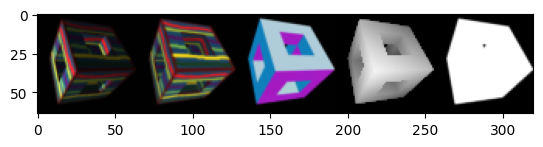

In [551]:
numbero_uno = 2 # 21 - pringle | 9 - donut
blurNormal = np.load('Sharpening/SharpenInputs/small_blurry_predictions.npy')[numbero_uno]
GetTestPicture(numbero_uno)
plt.imshow(np.concatenate([myPhoto, myAlbedo, myNormal, myDepth, myMask], axis = 1).astype("float32"))
#plt.imshow(myPhoto.astype("float32"))

In [5]:
# Вообще не думал что такая простая задача, как рисование линии, затянет меня на целый день. 
# GPT задачу не понимает, он выдает алгорит Bresenham-а каждый раз
# В интернете абсолютный вакуум, только один reddit: https://www.reddit.com/r/askmath/comments/pr4mr0/is_there_a_formula_for_determining_what_tiles_in/

In [6]:
def distance_point_to_line(A, B, C, x0, y0):
    distance = abs(A * x0 + B * y0 + C) / math.sqrt(A**2 + B**2)
    return distance
def vector_line(x0, y0, x1, y1):
    A = y1 - y0
    B = x0 - x1
    C = x1 * y0 - x0 * y1
    return A, B, C

In [7]:
def perpendicular_from_point_to_line(A, B, C, x0, y0):
    if A == 0: 
        x_perpendicular = x0
        y_perpendicular = -C / B
    elif B == 0: 
        x_perpendicular = -C / A
        y_perpendicular = y0
    else:
        m_perpendicular = B / A
        x_perpendicular = (-B * y0 + B * m_perpendicular * x0 - C) / (A + B * m_perpendicular)
        y_perpendicular = m_perpendicular * (x_perpendicular - x0) + y0
    return x_perpendicular, y_perpendicular

# Вроде работае?
A, B, C = vector_line(0, 0, 1, 1)
x0 = 0
y0 = 1
print(A,B,C)
x_perpendicular, y_perpendicular = perpendicular_from_point_to_line(A, B, C, x0, y0)
dist_dist = distance_point_to_line(A, B, C, x0, y0)
print(dist_dist) # должно получиться sqrt(2), тоесть 0.7???...
print(f"Координаты точки пересечения перпендикуляра: ({x_perpendicular:.2f}, {y_perpendicular:.2f})")

1 -1 0
0.7071067811865475
Координаты точки пересечения перпендикуляра: (0.50, 0.50)


In [8]:
def clamp(n, my_min, my_max): 
    if n < my_min: 
        return my_min
    elif n > my_max: 
        return my_max
    else: 
        return n 

In [304]:
def ratio_perp(x0, y0, x1, y1, # line points
              a0, a1): # actual point
    A, B, C = vector_line(x0, y0, x1, y1)
    distance = distance_point_to_line(A, B, C, a0, a1)
    px, py = perpendicular_from_point_to_line(A, B, C, a0, a1)
    ratio = 10
    if abs((x1 - x0)) > 0.001:
        ratio = (px - x0) / (x1 - x0)
    elif abs((y1 - y0)) > 0.001:
        ratio = (py - y0) / (y1 - y0)
    
    return ratio, distance
print(ratio_perp(-10, -10, 5, 5, -1, 1))  
print(ratio_perp(32, -149, 8, 18, 11, 0))
# возвращает отношение и расстояние до точки. Можно проще все это сделать, но мне лень.

(0.6666666666666666, 1.414213562373095)
(0.891867205339891, 0.4089719259127555)


In [256]:
def XYZ_to_world(x, y, z):
    return x / 64 - 0.5, y / 64 - 0.5, z - 0.5
def Light_to_grid(light_pos):
    x, y, z = light_pos # Z не нужен
    x = x + 0.5; y = y + 0.5;
    x = x * 64; y = y * 64
    x = round(x); y = round(y)
    return x, y

In [11]:
def try_paint(x, y):
    if x < 0 or y < 0: return False
    if x > 63 or y > 63: return False
    return True

In [257]:
# Хороший вариант честно спизженный отсюда:
# https://github.com/mitchcurtis/grid-line-intersection/blob/master/main.cpp
# Вариант очень хороший, я немного модифицировал его так чтобы он закрашивал клетки даже когда пересекается с углом.
# Но наверное это ролять не будет. Но все равно. 
# Его проблема в том что он принимает только integer значения
def rayCast(x0, y0, x1, y1, avoid_exorbants = False): 
    candidates = []

    dx = abs(x1 - x0);
    dy = abs(y1 - y0);
    x = x0;
    y = y0;
    n = 1 + dx + dy;
    x_inc = 1 if x1 > x0 else -1
    y_inc = 1 if y1 > y0 else -1
    error = dx - dy;
    dx *= 2;
    dy *= 2;
    while n > 0:
        n = n - 1
        if try_paint(x, y):
            candidates.append((x, y))
        if (error > 0):
            x += x_inc;
            error -= dy;
        elif (error < 0):
            y += y_inc;
            error += dx;
        elif (error == 0) :
            if avoid_exorbants == False:
                if try_paint(x + x_inc, y):
                    candidates.append((x, y))
                if try_paint(x, y + y_inc):
                    candidates.append((x, y))
            x += x_inc;
            y += y_inc;
            error -= dy;
            error += dx;
            n = n - 1;

    return candidates

In [258]:
def get_light_ray_pic(pixel_list):
    new_photo = np.zeros((64,64,3))
    for cell in pixel_list:
        new_photo[cell[0], cell[1]] = [1,1,1]
    return new_photo

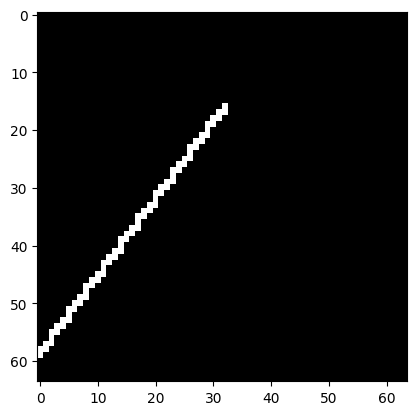

In [259]:
plt.imshow(get_light_ray_pic(rayCast(72, -10, 16, 32, False)))

In [490]:
def volume_shadow(depth_map, light_pos, treshhold, column_fat, column_sub_scat = 0.001):
    print("FRAME GEN BEGUN...")
    loc_depth_map = depth_map[:,:, 0]
    new_photo = np.zeros((64,64,3))
    l_x, l_y = Light_to_grid(light_pos)
    l_z = light_pos[2]
    for x in range(0,64, 1): # ПОМЕНЯТЬ!
        for y in range(0, 64, 1):
            new_color = can_reach_pixel(loc_depth_map, (l_x, l_y, l_z), x, y, treshhold, column_fat, column_sub_scat)
            new_photo[x,y] = [new_color,new_color,new_color]
    print("FRAME GEN FINISHED!")
    return new_photo

In [516]:
def can_reach_pixel(depth_map, light_pos, x, y, treshhold, column_fat, column_sub_scat = 0.001):
    reverse_css = 1 / column_sub_scat
    new_x, new_y, z = light_pos[0], light_pos[1], light_pos[2]
    illumination = 1
    point_list = rayCast(new_x, new_y, x, y, False)
    debug_info = ""
    #print("=" * 10, "START " + str(z) + " END " + str(depth_map[x, y]), "=" * 10)
    for point in point_list:
        ratio, distance = ratio_perp(new_x, new_y, x, y, point[0], point[1])
        #print(new_x, new_y, x, y, point[0], point[1], "R&D:", ratio, distance)
        
        if try_paint(point[0], point[1]):
            light_height = z - (z - depth_map[x, y]) * ratio
            h_diff = depth_map[point[0], point[1]] - light_height
            #debug_info = (debug_info + "L:" + str(round(illumination, 2)) +  "LH" + str(round(light_height, 2)))
            if  h_diff > treshhold: 
                if illumination < 0.01:
                    illumination = 0
                    break
                neomod = clamp(column_sub_scat - h_diff, 0, column_sub_scat)  * reverse_css
                illumination = illumination * neomod
                #illumination = illumination * clamp(distance * 2 - column_fat, 0, 1)
                #print("LH", round(light_height, 4), "DM", round(depth_map[point[0], point[1]], 4), "HD", round(h_diff, 4), "NM", round(neomod,4))
                """
                debug_info +=(  "D: " + str(round(distance, 2)) + 
                                "H_diff" + str(round(h_diff, 4)) +
                                " neomod " + str(round(neomod, 4)) +
                                "Coord: " + str((round(point[0], 3), round(point[1], 3))) +  
                                "DM: " + str(round(depth_map[point[0], point[1]], 3)) + 
                                " LH: " + str(round(light_height, 3))
                             )  
                """
                
    #if illumination  < 0.8: print(debug_info)
    return illumination
    

In [553]:
my_thing = volume_shadow(myDepth, [-2, -2, 0.8], 0.00001, 0.05, 0.25)
print(my_thing.shape)

FRAME GEN BEGUN...
FRAME GEN FINISHED!
(64, 64, 3)


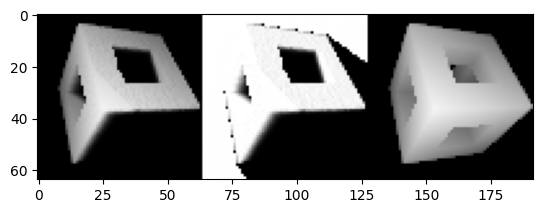

In [554]:
plt.imshow(np.concatenate([myDepth * my_thing, my_thing, myDepth], axis=1))

In [555]:
def rotate_vector(my_vector, degrees):
    x, y = my_vector
    pies = math.radians(degrees)
    new_x = x * math.cos(pies) - y * math.sin(pies)
    new_y = x * math.sin(pies) + y * math.cos(pies)
    return (round(new_x, 2),round(new_y, 2))
    
vector_list = np.zeros((24, 3))
vector_to_add = [0, -2, 0.8]
for i in range(24):
    new_x, new_y = rotate_vector((vector_to_add[0], vector_to_add[1]), 15 * i)
    vector_list[i][0] = new_x
    vector_list[i][1] = new_y
    vector_list[i][2] = vector_to_add[2]
print(vector_list, myVector)


[[ 0.   -2.    0.8 ]
 [ 0.52 -1.93  0.8 ]
 [ 1.   -1.73  0.8 ]
 [ 1.41 -1.41  0.8 ]
 [ 1.73 -1.    0.8 ]
 [ 1.93 -0.52  0.8 ]
 [ 2.   -0.    0.8 ]
 [ 1.93  0.52  0.8 ]
 [ 1.73  1.    0.8 ]
 [ 1.41  1.41  0.8 ]
 [ 1.    1.73  0.8 ]
 [ 0.52  1.93  0.8 ]
 [ 0.    2.    0.8 ]
 [-0.52  1.93  0.8 ]
 [-1.    1.73  0.8 ]
 [-1.41  1.41  0.8 ]
 [-1.73  1.    0.8 ]
 [-1.93  0.52  0.8 ]
 [-2.    0.    0.8 ]
 [-1.93 -0.52  0.8 ]
 [-1.73 -1.    0.8 ]
 [-1.41 -1.41  0.8 ]
 [-1.   -1.73  0.8 ]
 [-0.52 -1.93  0.8 ]] [-0.565 -0.819  0.1  ]


In [556]:
relit_albedos = np.zeros((24, 64,64,3))
for i in range(24):
    relit_albedos[i] = myAlbedo * volume_shadow(myDepth, vector_list[i], 0.00001, 0.05, 0.15)
final_image = np.concatenate([
    np.concatenate(relit_albedos[0:6], axis = 1),
    np.concatenate(relit_albedos[6:12], axis = 1),
    np.concatenate(relit_albedos[12:18], axis = 1),
    np.concatenate(relit_albedos[18:24], axis = 1)   
    ], axis = 0 )

FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!
FRAME GEN BEGUN...
FRAME GEN FINISHED!


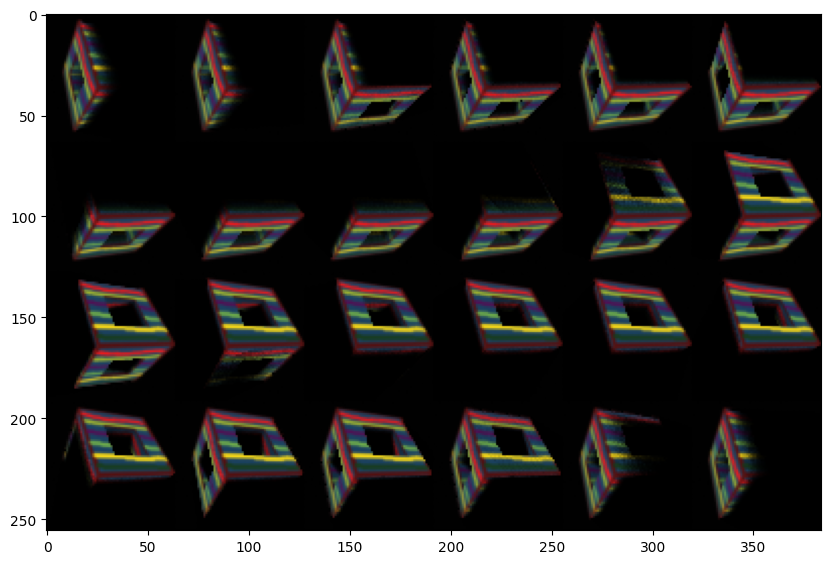

In [563]:
plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(final_image)

In [558]:
# GIFMAKER
images_array = (relit_albedos * 255).astype(np.uint8)
images = []
for img in images_array:
    images.append(Image.fromarray(img).resize((128, 128)))

images[0].save('donut_height0_8_sss_0_1.gif',
               save_all=True,
               append_images=images[1:],
               duration=100, 
               loop=0)

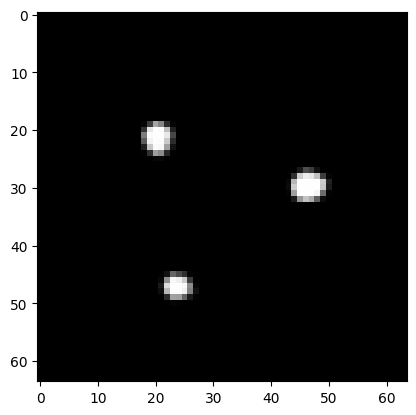

In [337]:
plt.imshow(TrioDot.astype("float32"))